Hunter Bennett | Glass Lab | Kupffer Strains Project | April 27 2021  
This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks annotated with H3K27Ac ChIP-seq data (or other histone modified data) from three strains (c57, balb, and aj) and compares each strain to the other pairwise. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [19]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

In [21]:
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_kc_control_atac_peaks_all.txt')

In [22]:
mat.columns

Index(['/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208',
       '/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208',
       '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_aj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_AJ1104_TDT_l20201212_GGCTTAAG_TCGTGACC_S29_L001.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
       '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
       '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_balbcj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_BALB1104_TDT_l20201212_AATCCGGA_CTACAGTT_S30_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
       '/home/h1bennet/strains/data/H3K2

In [23]:
best_reps = ['/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208',
             '/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208',
             '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_aj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_AJ1104_TDT_l20201212_GGCTTAAG_TCGTGACC_S29_L001.aj.bowtie2_shifted_from_AJ.sam',
             '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
             '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
             '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_balbcj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_BALB1104_TDT_l20201212_AATCCGGA_CTACAGTT_S30_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam',
             '/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
             '/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
             '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_c57bl6j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_C571104_TDT_l20201212_TAATACAG_ATATTCAC_S31_L001.c57bl6j.bowtie2_shifted_from_C57BL6J.sam']

In [24]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_raw_kc_control_atac_peaks_all.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]

df.to_csv('./merged_peaks/ann_raw_kc_control_atac_peaks_filtered.txt', sep='\t')

In [25]:
mat.columns

Index(['/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208',
       '/home/h1bennet/strains/data/H3K27Ac/control/02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208',
       '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_aj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_AJ1104_TDT_l20201212_GGCTTAAG_TCGTGACC_S29_L001.aj.bowtie2_shifted_from_AJ.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
       '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
       '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_balbcj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_BALB1104_TDT_l20201212_AATCCGGA_CTACAGTT_S30_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
       '/home/h1bennet/strains/data/H3K2

In [26]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./merged_peaks/ann_raw_kc_control_atac_peaks_filtered.txt \
# aj aj aj \
# balbcj balbcj balbcj \
# c57bl6j c57bl6j c57bl6j \
# -AvsA -peaks > ./merged_peaks/diff_output.txt

### Import differential peaks

In [27]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (86301, 27)
getDiffExpression selected transcripts (84264, 36)
annotatePeaks selected peaks (84264, 27)


In [28]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [29]:
comp_dict.keys()

dict_keys(['aj vs. balbcj', 'aj vs. c57bl6j', 'balbcj vs. c57bl6j'])

In [30]:
comps = ['aj vs. balbcj',
         'aj vs. c57bl6j',
         'balbcj vs. c57bl6j']

groups = [[[0,1,2],[3,4,5]],
         [[0,1,2],[6,7,8]],
         [[3,4,5],[6,7,8]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)

colors = [['#e41a1c', '#377eb8'],
          ['#e41a1c', '#4daf4a'],
          ['#377eb8', '#4daf4a']]

In [13]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N peaks down', np.sum((de.adj_pval <= 0.05) & (de.log2fc < 0)))
    print('N peaks up', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 0)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,14.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(14.5,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    plt.close()

aj vs. balbcj
N peaks down 912
N peaks up 1385

aj vs. c57bl6j
N peaks down 1772
N peaks up 2554

balbcj vs. c57bl6j
N peaks down 2767
N peaks up 2953



# Cluster differential enhancers:

### all enhancers

3171


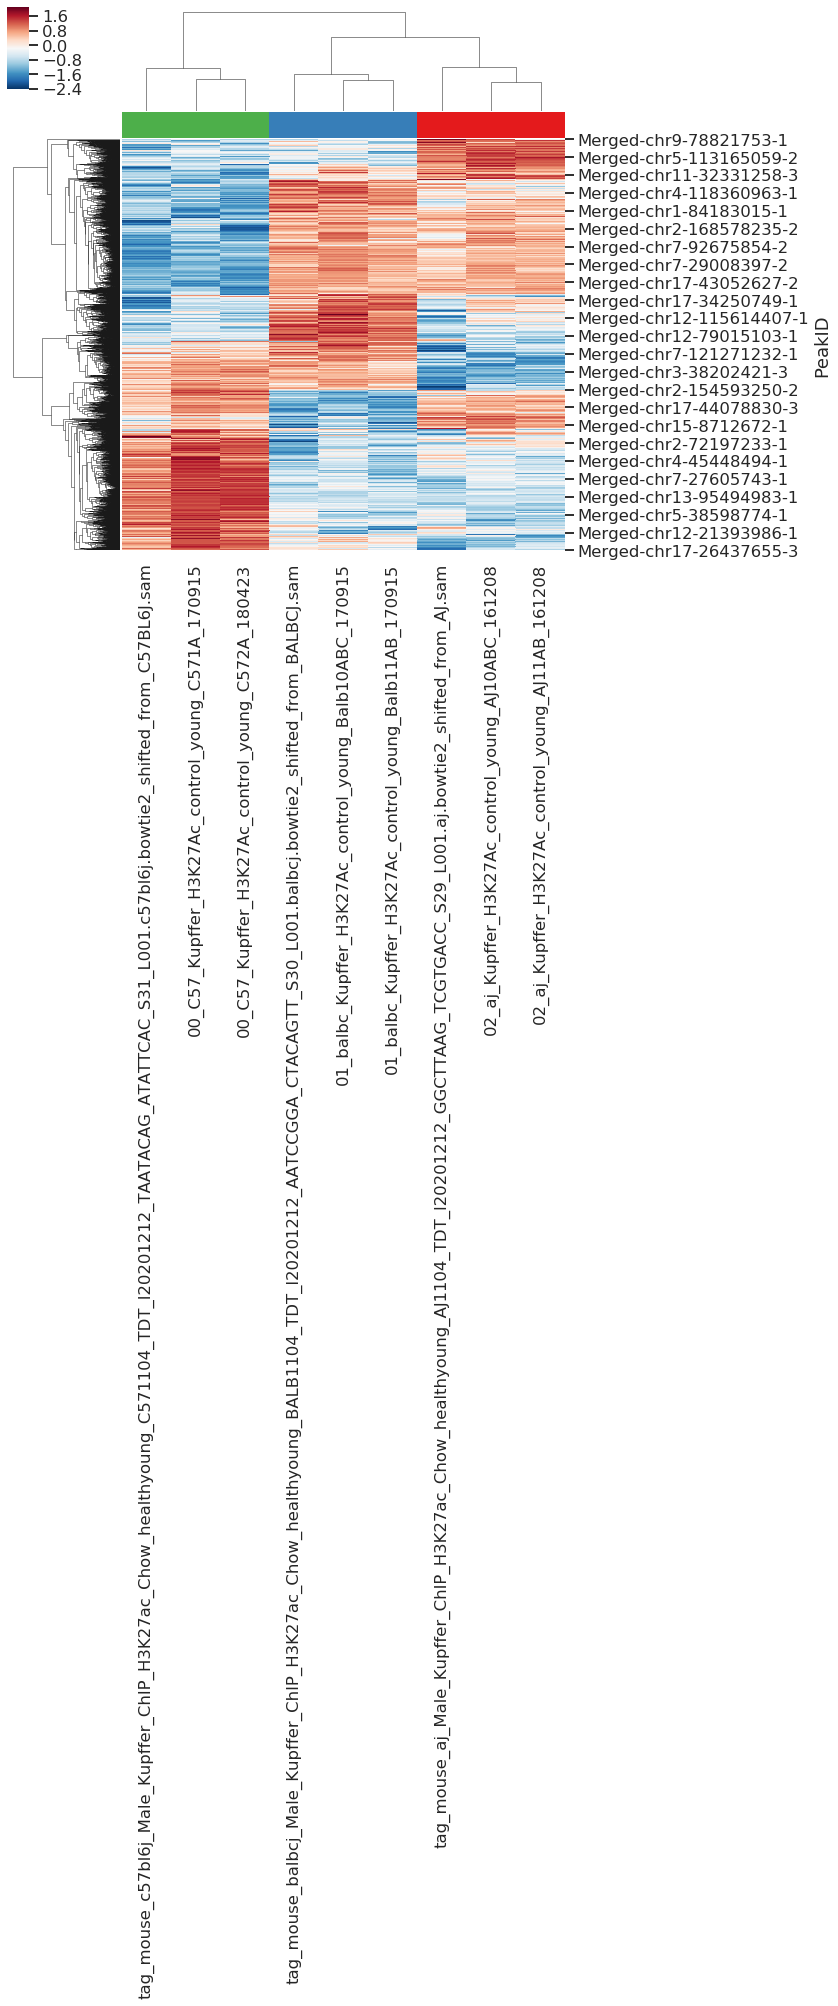

In [14]:
pval = 0.05
fc = 1

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_id.extend(de.loc[((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)), :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#e41a1c', '#e41a1c', '#e41a1c',
                           '#377eb8', '#377eb8', '#377eb8',
                           '#4daf4a', '#4daf4a', '#4daf4a'])
plt.savefig('./figures/diff_peaks_clustermap.png', bbox_inches='tight')

### distal enhancers only

2580


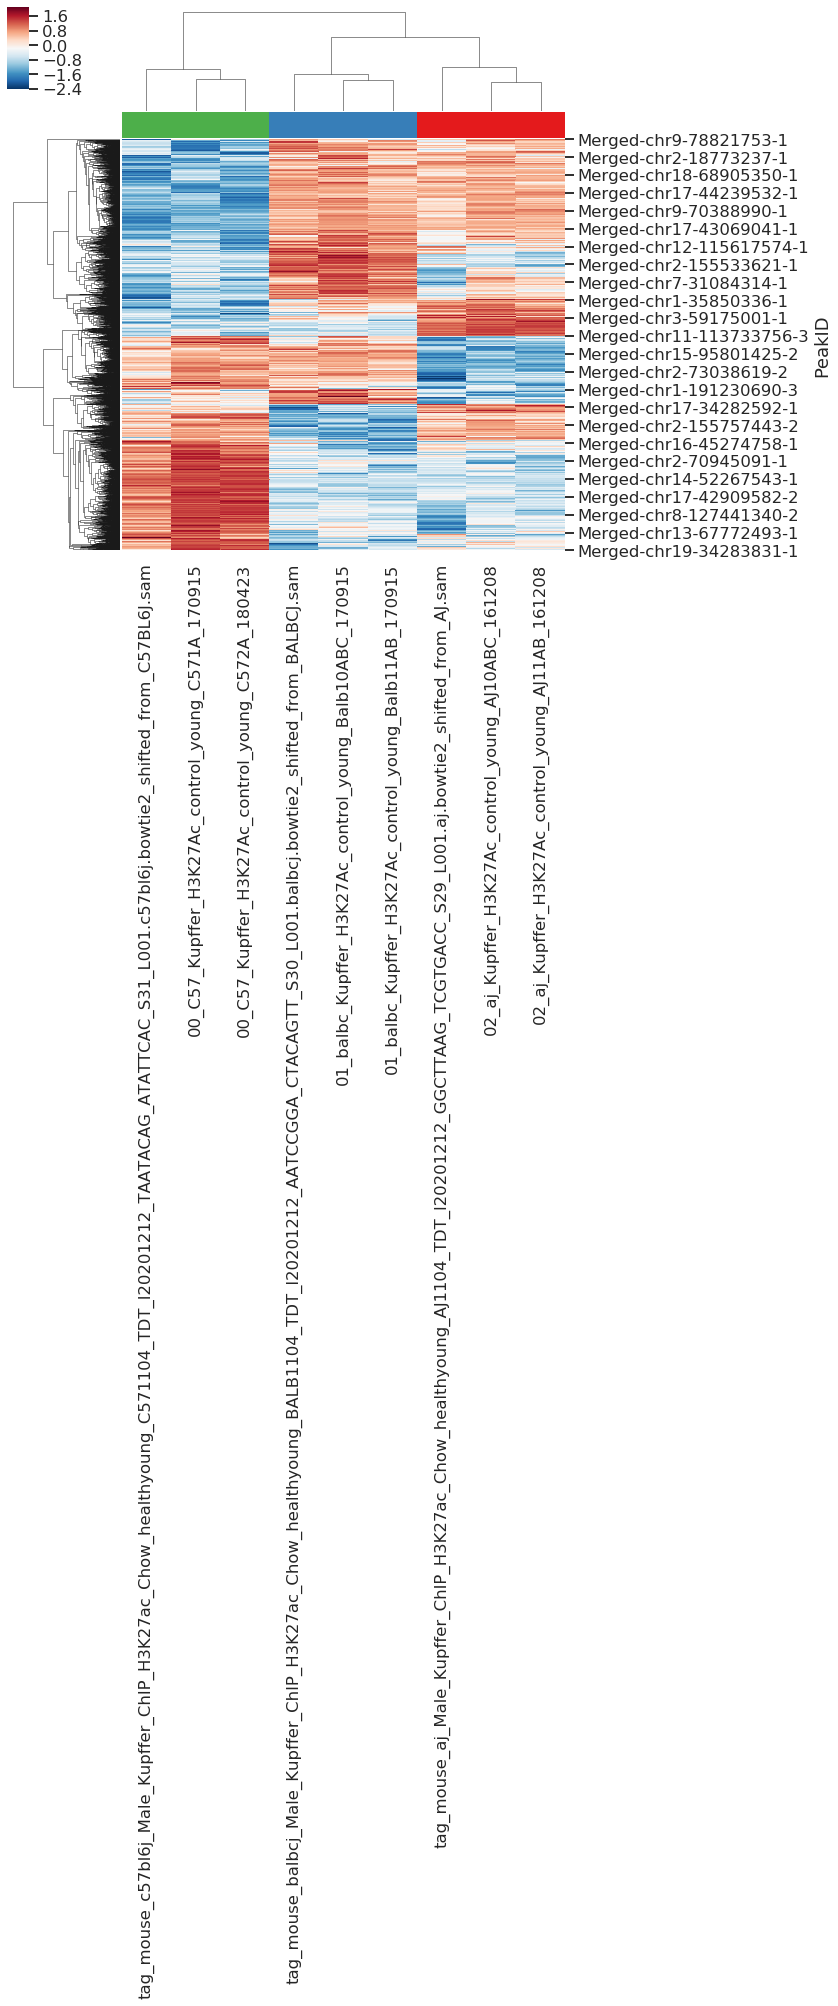

In [15]:
pval = 0.05
fc = 1

# grab differential enhancers for each comparison
sig_peaks_id = []
for comp in comps:
    de = comp_dict[comp]
    sig_peaks_bool = (((de.adj_pval <= pval) & (np.abs(de.log2fc) >= fc)) & (np.abs(de.TSS_dist) >= 3000))
    sig_peaks_id.extend(de.loc[sig_peaks_bool, :].index.tolist())

sig_peaks_id = np.unique(sig_peaks_id)
print(len(sig_peaks_id))
sig_peaks = peak_mat.reindex(sig_peaks_id)
sig_peaks.columns = sig_peaks.columns.str.split('/').str[-1].str.split(' Tag Count').str[0]

sns.clustermap(np.log2(sig_peaks+1),
               z_score=0,
               cmap='RdBu_r',
               col_colors=['#e41a1c', '#e41a1c', '#e41a1c',
                           '#377eb8', '#377eb8', '#377eb8',
                           '#4daf4a', '#4daf4a', '#4daf4a'])
plt.savefig('./figures/diff_peaks_distal_clustermap.png', bbox_inches='tight')

# Save differential peaks for analysis in GREAT

In [31]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

In [32]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['aj',
         'balbcj',
         'c57bl6j']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)
        
        # store pairwise differential
        # strain 1
        pairwise_key = key.replace(' vs. ', '_vs_')+'_'+key.split(' vs. ')[0]+'_up'
        sig_peaks = df.index[(df['adj_pval'] < pval) & (df['log2fc'] <= -fc)].to_list()
        peak_lists[pairwise_key] = list(sig_peaks)
        # strain 2
        pairwise_key = key.replace(' vs. ', '_vs_')+'_'+key.split(' vs. ')[1]+'_up'
        sig_peaks = df.index[(df['adj_pval'] < pval) & (df['log2fc'] >= fc)].to_list()
        peak_lists[pairwise_key] = list(sig_peaks)



        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing aj ...

0
For comp: aj vs. balbcj
Union set at: 815 peaks
Intersection set at: 815 peaks

1
For comp: aj vs. c57bl6j
Union set at: 2155 peaks
Intersection set at: 280 peaks

2
For comp: balbcj vs. c57bl6j
Union set at: 2155 peaks
Intersection set at: 280 peaks

Analyzing balbcj ...

0
For comp: aj vs. balbcj
Union set at: 1260 peaks
Intersection set at: 1260 peaks

1
For comp: aj vs. c57bl6j
Union set at: 1260 peaks
Intersection set at: 1260 peaks

1
For comp: balbcj vs. c57bl6j
Union set at: 3269 peaks
Intersection set at: 465 peaks

Analyzing c57bl6j ...

0
For comp: aj vs. balbcj
Union set at: 3269 peaks
Intersection set at: 465 peaks

0
For comp: aj vs. c57bl6j
Union set at: 2246 peaks
Intersection set at: 2246 peaks

1
For comp: balbcj vs. c57bl6j
Union set at: 3398 peaks
Intersection set at: 1245 peaks



### For annotated peaks we want to pull the peak locations from the original merged ATAC-seq file

In [14]:
atac_peaks = pd.read_csv('./merged_peaks/idr_peaks_merged.txt', sep='\t', index_col=0)

In [15]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.start + int(np.floor((row.end - row.start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['start'] = new_start
atac_peaks_200bp['end'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [16]:
convert_dict = {'start': int,
                'end': int}

In [17]:
for key in peak_lists.keys():
    # save cell specific promoters
    tmp = atac_peaks_200bp.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    # filter unknown chromosomes
    tmp = tmp.loc[~tmp.chr.str.contains('random'), :]
    tmp.to_csv('./great_analysis/peak_files/'+key+'_act_peaks.txt',
               sep='\t')
        

Save full set of peaks for background

In [22]:
atac_peaks_200bp.iloc[:, :4].to_csv(
    './great_analysis/peak_files/all_peaks.txt',
    sep='\t')

Convert peaks to bed file

In [23]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

rm: cannot remove ‘./peak_to_bed_great.sh’: No such file or directory


In [24]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [25]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [26]:
!cp ./great_analysis/bed_files/* ./bed_files/

In [27]:
!ls ./bed_files/

aj_intersection_act_peaks.bed	   balbcj_union_act_peaks.bed
aj_union_act_peaks.bed		   c57bl6j_intersection_act_peaks.bed
all_peaks.bed			   c57bl6j_union_act_peaks.bed
balbcj_intersection_act_peaks.bed


### label for uploading to UCSC

In [28]:
with open('./label_bed.sh', 'w') as f:
    for i in glob.glob('./bed_files/*act_peaks.bed*'):

        strain = i.split('/')[-1].split('_')[0]
        settype = i.split('/')[-1].split('_')[1]
        group = "Control_Young"
        chip = 'H3K27Ac'

        # set track names for upload to ucsc genome browser
        lab = "'track name=\"%s_%s_%s_%s\" description=\"%s %s %s %s ChIP-seq DESeq2 \"'" % (strain, chip, group, settype, strain, group, chip, settype)
        lab_dist = "'track name=\"%s_%s_%s_%s_distal\" description=\"%s %s %s %s ChIP-seq DESeq2 \"'" % (strain, chip, group, settype, strain, group, chip, settype)

        # set labels - can't think of a more clever way to do this so we will just
        # use the simple if / else statement to switch labels depending on our 
        # peak set being distal or all
        
        if 'distal' in i:
            l = lab_dist
        else:
            l = lab
        
        label_track = ['echo', l, '|', 'cat', '-',
                       i,
                       '> temp && mv temp',
                       i, '\n']
    
        f.write(' '.join(label_track))
        
    f.close()

label all peaks post-hoc

In [30]:
%%bash

echo 'track name="kupffer_control_young_atac_merged" description="Kupffer Young Control ATAC All Strains"' \
| cat - ./bed_files/all_peaks.bed \
> temp && mv temp ./bed_files/all_peaks.bed

# Check bed files and peaks in browser

In [33]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [34]:
viz_cols = ['Gene Name', 'Gene Description', 'location', 'Annotation',
            'aj vs. balbcj Log2 Fold Change','aj vs. balbcj adj. p-value',
            'aj vs. c57bl6j Log2 Fold Change', 'aj vs. c57bl6j adj. p-value',
            'balbcj vs. c57bl6j Log2 Fold Change', 'balbcj vs. c57bl6j adj. p-value']

In [35]:
diff_peak_viz = diff_peak.loc[:, viz_cols]

In [57]:
n_start = 200
diff_peak_viz.loc[peak_lists['c57bl6j_intersection'], :].sort_values(
    'aj vs. c57bl6j Log2 Fold Change', ascending=False).iloc[n_start:n_start+50]

,Gene Name,Gene Description,location,Annotation,aj vs. balbcj Log2 Fold Change,aj vs. balbcj adj. p-value,aj vs. c57bl6j Log2 Fold Change,aj vs. c57bl6j adj. p-value,balbcj vs. c57bl6j Log2 Fold Change,balbcj vs. c57bl6j adj. p-value
PeakID,,,,,,,,,,
Merged-chr8-33492499-2,Hmgb1-rs17,"high mobility group box 1, related sequence 17",chr8:33491997-33492997,Intergenic,1.021634,1.000000,3.768418,3.929865e-08,2.728595,3.690298e-06
Merged-chr19-16407908-3,Gna14,"guanine nucleotide binding protein, alpha 14",chr19:16407408-16408408,Intergenic,2.512726,0.000073,3.764897,2.920247e-15,1.271698,2.226575e-03
Merged-chr1-173599226-1,Ifi213,interferon activated gene 213,chr1:173598726-173599726,promoter-TSS (NM_001177349),-0.480628,1.000000,3.763966,8.911756e-08,4.277237,1.483971e-07
Merged-chr2-72201832-1,Map3k20,mitogen-activated protein kinase kinase kinase 20,chr2:72201332-72202332,"intron (NM_001355478, intron 11 of 26)",-0.698038,1.000000,3.757065,6.525196e-10,4.657064,2.862436e-11
Merged-chr17-79442790-1,4930429F11Rik,RIKEN cDNA 4930429F11 gene,chr17:79442290-79443290,Intergenic,0.021874,1.000000,3.732829,8.842557e-07,3.432523,1.614408e-06
Merged-chr9-48388642-1,Nxpe4,"neurexophilin and PC-esterase domain family, m...",chr9:48388142-48389142,"intron (NM_172921, intron 2 of 8)",1.303623,1.000000,3.728280,3.595983e-05,2.332990,1.366682e-03
Merged-chr1-173939522-1,Ifi203,interferon activated gene 203,chr1:173939022-173940022,"intron (NM_001302649, intron 2 of 9)",1.631703,1.000000,3.718867,4.254780e-04,2.076707,2.659354e-02
Merged-chr10-87696702-1,Igf1,insulin-like growth factor 1,chr10:87696202-87697202,Intergenic,0.068927,1.000000,3.711547,1.416831e-08,3.809727,1.844579e-09
Merged-chr11-96874986-1,Mir152,microRNA 152,chr11:96874486-96875486,Intergenic,2.384034,0.008916,3.707266,2.141890e-10,1.336927,6.398449e-03
